In [1]:
import warnings
warnings.filterwarnings('ignore')
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, q_stat
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from numpy.linalg import LinAlgError
# import pandas_datareader.data as web
import statsmodels.tsa.api as tsa
import matplotlib.pyplot as plt
from itertools import product
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import yfinance as yf

sns.set_style('darkgrid')

btc = yf.download('BTC-USD', start='2017-01-01')

btc_returns = np.log(btc['Adj Close']).diff().dropna()

[*********************100%%**********************]  1 of 1 completed


In [8]:
def plot_correlogram(x, lags=None, title=None):
    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Residuals')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f})'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:>12.2f}\nKurtosis: {kurtosis:>9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x=x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)
    return


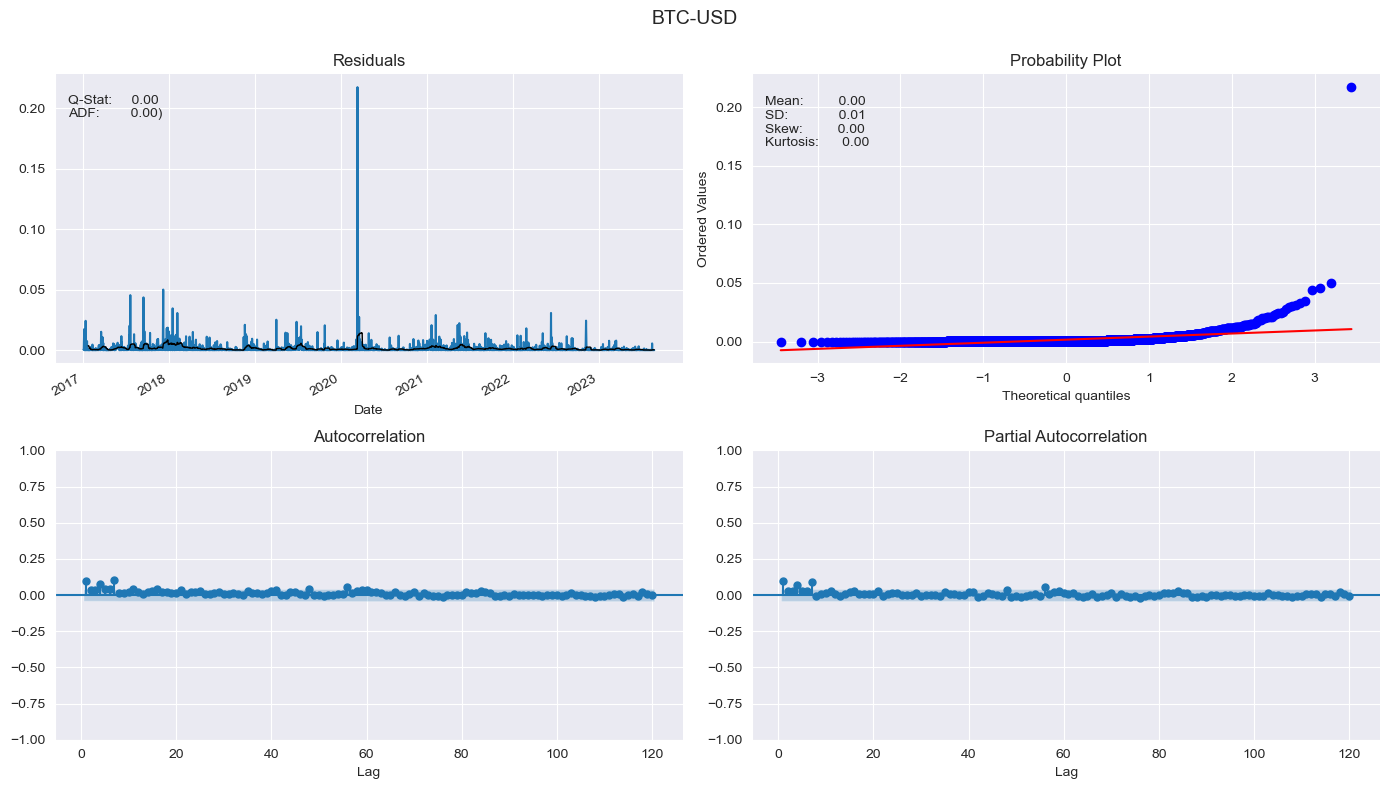

In [10]:
btc_daily_vol = (btc_returns - btc_returns.mean())**2

plot_correlogram(x=btc_daily_vol, title='BTC-USD', lags=120)

In [11]:
from arch import arch_model

trainsize = 5 * 365

data = btc_returns.clip(lower=btc_returns.quantile(.05),
                        upper=btc_returns.quantile(.95))

T = len(btc_returns)

results = {}

for p in range(1, 5):
    for q in range(1, 5):
        print(f'{p} | {q}')
        result = []

        for s, t in enumerate(range(trainsize, T-1)):
            train_set = data.iloc[s:t]
            test_set = data.iloc[t+1]
            model = arch_model(y=train_set, p=p, q=q).fit(disp='off')
            forecats = model.forecast(horizon=1)
            mu = forecats.mean.iloc[-1, 0]
            var = forecats.variance.iloc[-1, 0]

            result.append([(test_set-mu)**2, var])
        df = pd.DataFrame(result, columns=['y_true', 'y_pred'])
        results[(p, q)] = np.sqrt(mean_squared_error(df.y_true, df.y_pred))

1 | 1
1 | 2
1 | 3
1 | 4
2 | 1
2 | 2
2 | 3
2 | 4
3 | 1
3 | 2
3 | 3
3 | 4
4 | 1
4 | 2
4 | 3
4 | 4


In [13]:
pd.DataFrame(results, index=pd.Series(0)).unstack().idxmin()

(3, 3, 0)

In [43]:
data = btc_returns.clip(lower=btc_returns.quantile(.05),
                        upper=btc_returns.quantile(.95))

best_model = arch_model(y=data, p=3, q=3).fit(update_freq=5, disp='off')

print(best_model.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                5123.73
Distribution:                  Normal   AIC:                          -10231.5
Method:            Maximum Likelihood   BIC:                          -10185.1
                                        No. Observations:                 2427
Date:                Sat, Aug 26 2023   Df Residuals:                     2426
Time:                        08:37:08   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.1686e-03  5.432e-04      2.151  3.146e-02 [1.

In [44]:
data = btc_returns.to_frame('btc_log_returns')
data['variance'] = data['btc_log_returns'].rolling(70).var()
data = data['2021':]
def predict_volatility(x):
    best_model = arch_model(y=x, p=3, q=3).fit(update_freq=5, disp='off')
    variance_forecast = best_model.forecast(horizon=1).variance.iloc[-1, 0]
    print(x.index[-1])
    return variance_forecast

data['prediction'] = data['btc_log_returns'].rolling(70).apply(lambda x: predict_volatility(x))
data = data.dropna()

data

2021-03-11 00:00:00
2021-03-12 00:00:00
2021-03-13 00:00:00
2021-03-14 00:00:00
2021-03-15 00:00:00
2021-03-16 00:00:00
2021-03-17 00:00:00
2021-03-18 00:00:00
2021-03-19 00:00:00
2021-03-20 00:00:00
2021-03-21 00:00:00
2021-03-22 00:00:00
2021-03-23 00:00:00
2021-03-24 00:00:00
2021-03-25 00:00:00
2021-03-26 00:00:00
2021-03-27 00:00:00
2021-03-28 00:00:00
2021-03-29 00:00:00
2021-03-30 00:00:00
2021-03-31 00:00:00
2021-04-01 00:00:00
2021-04-02 00:00:00
2021-04-03 00:00:00
2021-04-04 00:00:00
2021-04-05 00:00:00
2021-04-06 00:00:00
2021-04-07 00:00:00
2021-04-08 00:00:00
2021-04-09 00:00:00
2021-04-10 00:00:00
2021-04-11 00:00:00
2021-04-12 00:00:00
2021-04-13 00:00:00
2021-04-14 00:00:00
2021-04-15 00:00:00
2021-04-16 00:00:00
2021-04-17 00:00:00
2021-04-18 00:00:00
2021-04-19 00:00:00
2021-04-20 00:00:00
2021-04-21 00:00:00
2021-04-22 00:00:00
2021-04-23 00:00:00
2021-04-24 00:00:00
2021-04-25 00:00:00
2021-04-26 00:00:00
2021-04-27 00:00:00
2021-04-28 00:00:00
2021-04-29 00:00:00


/Users/pavelbryantsev/miniforge3/envs/dscience/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2021-12-25 00:00:00
2021-12-26 00:00:00
2021-12-27 00:00:00
2021-12-28 00:00:00
2021-12-29 00:00:00
2021-12-30 00:00:00
2021-12-31 00:00:00
2022-01-01 00:00:00
2022-01-02 00:00:00
2022-01-03 00:00:00
2022-01-04 00:00:00
2022-01-05 00:00:00
2022-01-06 00:00:00
2022-01-07 00:00:00
2022-01-08 00:00:00
2022-01-09 00:00:00
2022-01-10 00:00:00
2022-01-11 00:00:00
2022-01-12 00:00:00
2022-01-13 00:00:00
2022-01-14 00:00:00
2022-01-15 00:00:00
2022-01-16 00:00:00
2022-01-17 00:00:00
2022-01-18 00:00:00
2022-01-19 00:00:00
2022-01-20 00:00:00
2022-01-21 00:00:00
2022-01-22 00:00:00
2022-01-23 00:00:00
2022-01-24 00:00:00
2022-01-25 00:00:00
2022-01-26 00:00:00
2022-01-27 00:00:00
2022-01-28 00:00:00
2022-01-29 00:00:00
2022-01-30 00:00:00
2022-01-31 00:00:00
2022-02-01 00:00:00
2022-02-02 00:00:00
2022-02-03 00:00:00
2022-02-04 00:00:00
2022-02-05 00:00:00
2022-02-06 00:00:00
2022-02-07 00:00:00
2022-02-08 00:00:00
2022-02-09 00:00:00
2022-02-10 00:00:00
2022-02-11 00:00:00
2022-02-12 00:00:00


/Users/pavelbryantsev/miniforge3/envs/dscience/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2023-02-10 00:00:00
2023-02-11 00:00:00
2023-02-12 00:00:00
2023-02-13 00:00:00
2023-02-14 00:00:00
2023-02-15 00:00:00
2023-02-16 00:00:00
2023-02-17 00:00:00
2023-02-18 00:00:00
2023-02-19 00:00:00
2023-02-20 00:00:00
2023-02-21 00:00:00
2023-02-22 00:00:00
2023-02-23 00:00:00
2023-02-24 00:00:00
2023-02-25 00:00:00


/Users/pavelbryantsev/miniforge3/envs/dscience/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2023-02-26 00:00:00
2023-02-27 00:00:00
2023-02-28 00:00:00
2023-03-01 00:00:00
2023-03-02 00:00:00
2023-03-03 00:00:00
2023-03-04 00:00:00
2023-03-05 00:00:00
2023-03-06 00:00:00
2023-03-07 00:00:00
2023-03-08 00:00:00
2023-03-09 00:00:00
2023-03-10 00:00:00
2023-03-11 00:00:00
2023-03-12 00:00:00
2023-03-13 00:00:00
2023-03-14 00:00:00
2023-03-15 00:00:00
2023-03-16 00:00:00
2023-03-17 00:00:00
2023-03-18 00:00:00
2023-03-19 00:00:00
2023-03-20 00:00:00
2023-03-21 00:00:00


/Users/pavelbryantsev/miniforge3/envs/dscience/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2023-03-22 00:00:00
2023-03-23 00:00:00
2023-03-24 00:00:00
2023-03-25 00:00:00
2023-03-26 00:00:00
2023-03-27 00:00:00
2023-03-28 00:00:00
2023-03-29 00:00:00
2023-03-30 00:00:00
2023-03-31 00:00:00


/Users/pavelbryantsev/miniforge3/envs/dscience/lib/python3.10/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2023-04-01 00:00:00
2023-04-02 00:00:00
2023-04-03 00:00:00
2023-04-04 00:00:00
2023-04-05 00:00:00
2023-04-06 00:00:00
2023-04-07 00:00:00
2023-04-08 00:00:00
2023-04-09 00:00:00
2023-04-10 00:00:00
2023-04-11 00:00:00
2023-04-12 00:00:00
2023-04-13 00:00:00
2023-04-14 00:00:00
2023-04-15 00:00:00
2023-04-16 00:00:00
2023-04-17 00:00:00
2023-04-18 00:00:00
2023-04-19 00:00:00
2023-04-20 00:00:00
2023-04-21 00:00:00
2023-04-22 00:00:00
2023-04-23 00:00:00
2023-04-24 00:00:00
2023-04-25 00:00:00
2023-04-26 00:00:00
2023-04-27 00:00:00
2023-04-28 00:00:00
2023-04-29 00:00:00
2023-04-30 00:00:00
2023-05-01 00:00:00
2023-05-02 00:00:00
2023-05-03 00:00:00
2023-05-04 00:00:00
2023-05-05 00:00:00
2023-05-06 00:00:00
2023-05-07 00:00:00
2023-05-08 00:00:00
2023-05-09 00:00:00
2023-05-10 00:00:00
2023-05-11 00:00:00
2023-05-12 00:00:00
2023-05-13 00:00:00
2023-05-14 00:00:00
2023-05-15 00:00:00
2023-05-16 00:00:00
2023-05-17 00:00:00
2023-05-18 00:00:00
2023-05-19 00:00:00
2023-05-20 00:00:00


,btc_log_returns,variance,prediction
Date,,,
2021-03-11,0.031573,0.002620,0.001775
2021-03-12,-0.008217,0.002624,0.002545
2021-03-13,0.065990,0.002578,0.001958
2021-03-14,-0.032203,0.002600,0.001594
2021-03-15,-0.058955,0.002650,0.002614
...,...,...,...
2023-08-21,-0.002502,0.000332,0.000418
2023-08-22,-0.003546,0.000333,0.000103
2023-08-23,0.015248,0.000321,0.000320


<Axes: title={'center': 'BTC-USD Volatility Forecast'}, xlabel='Date'>

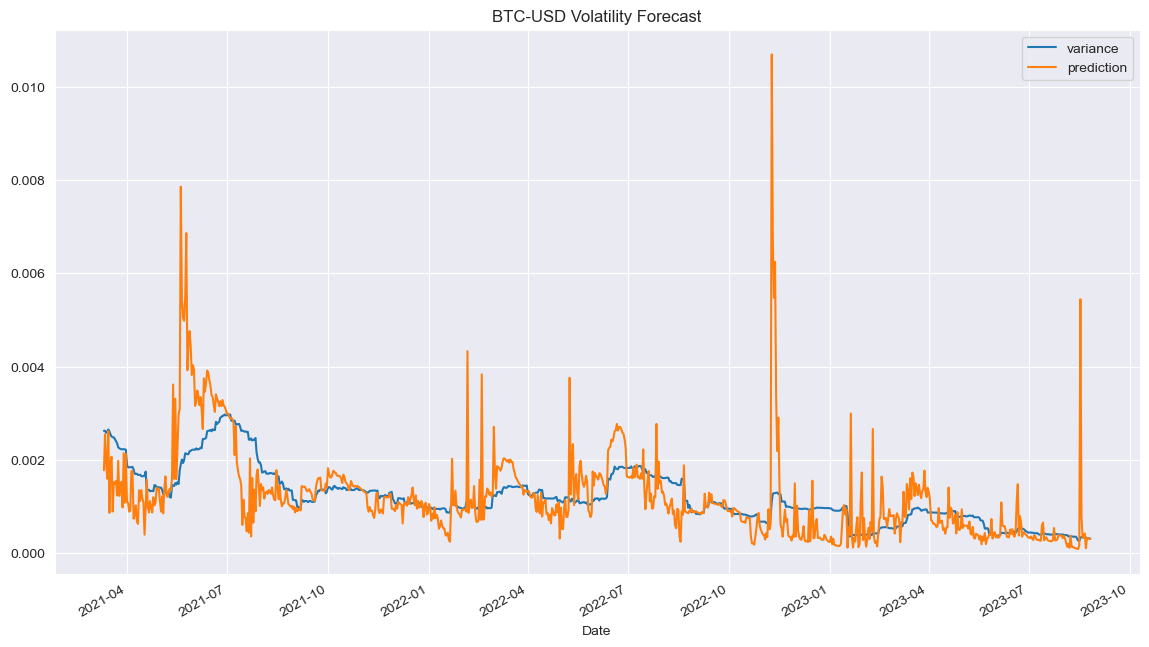

In [45]:
data[['variance', 'prediction']].plot(figsize=(14, 8), title='BTC-USD Volatility Forecast')

In [46]:
from pykalman import KalmanFilter

def KalmanFilterAverage(x):
    # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices=[1],
                      observation_matrices=[1],
                      initial_state_mean=0,
                      initial_state_covariance=1,
                      observation_covariance=1,
                      transition_covariance=.01)

    # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)

    return state_means

data['fixed_predictions'] = KalmanFilterAverage(data['prediction'])

data

,btc_log_returns,variance,prediction,fixed_predictions
Date,,,,
2021-03-11,0.031573,0.002620,0.001775,0.000887
2021-03-12,-0.008217,0.002624,0.002545,0.001447
2021-03-13,0.065990,0.002578,0.001958,0.001579
2021-03-14,-0.032203,0.002600,0.001594,0.001582
2021-03-15,-0.058955,0.002650,0.002614,0.001769
...,...,...,...,...
2023-08-21,-0.002502,0.000332,0.000418,0.000615
2023-08-22,-0.003546,0.000333,0.000103,0.000566
2023-08-23,0.015248,0.000321,0.000320,0.000543


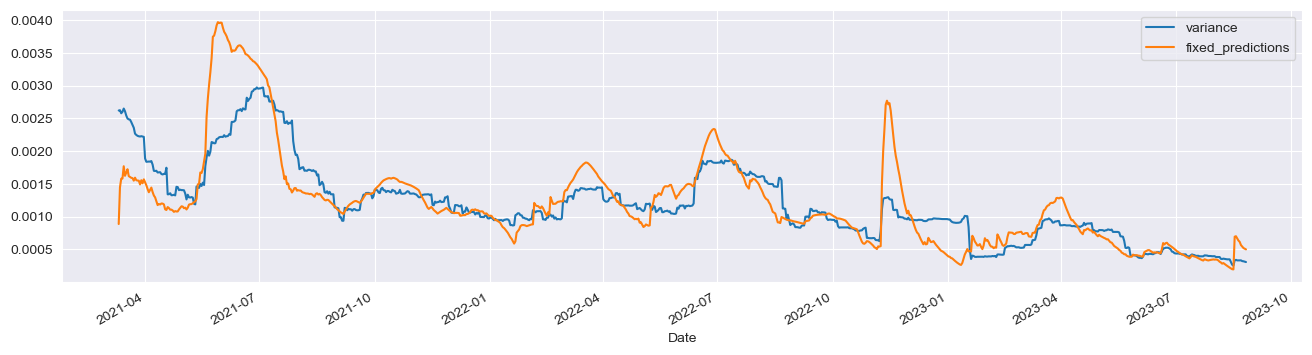

In [47]:
data[['variance', 'fixed_predictions']].plot(figsize=(16,4))
plt.show()

In [50]:
from datetime import datetime, timedelta


pred = best_model.forecast(horizon=14)
future_dates = [btc_returns.index[-1] + timedelta(days=i) for i in range(1,15)]
pred = pd.Series(np.sqrt(pred.variance.values[-1,:]), index=future_dates)

Text(0.5, 1.0, 'Volatility Prediction - Next 7 Days')

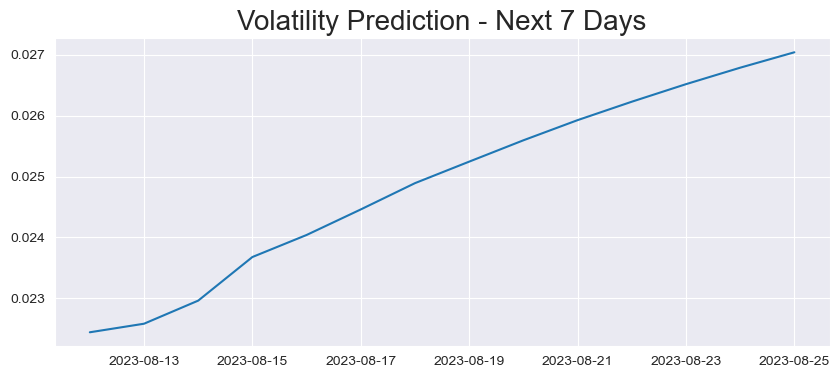

In [51]:
plt.figure(figsize=(10,4))
plt.plot(pred)
plt.title('Volatility Prediction - Next 7 Days', fontsize=20)